In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import h5py
import matplotlib.pyplot as plt

In [2]:
# Read the file
file = 'D:/Education/HRR/Ann reslt/new_spec_model/model_newspc_250.h5'
model = tf.keras.models.load_model(file)

model.summary()

Model: "Heat_release_rate"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 40)                1320      
_________________________________________________________________
h_layer1 (Dense)             (None, 24)                984       
_________________________________________________________________
h_layer2 (Dense)             (None, 24)                600       
_________________________________________________________________
output_layers (Dense)        (None, 1)                 25        
Total params: 2,929
Trainable params: 2,929
Non-trainable params: 0
_________________________________________________________________


In [3]:
f = 'D:\Education\HRR\chunk\Chunk_for_auto_diff.hdf5'
f1 = h5py.File(f, 'r')

In [4]:
# Get the data
X = f1.get('X_trainC')
Y = f1.get('Y_trainC')
print(X.shape, Y.shape )

(99999, 32) (99999, 1)


In [5]:
#Change the data type to varaible 
X = tf.Variable(X)
print(X)

<tf.Variable 'Variable:0' shape=(99999, 32) dtype=float32, numpy=
array([[4.9808690e-01, 1.5268852e-03, 5.5949847e-08, ..., 4.6616623e-01,
        3.3953732e-01, 5.4953533e-01],
       [9.1676277e-01, 2.3676723e-03, 3.6250869e-09, ..., 4.7412883e-02,
        2.5126025e-01, 7.9589957e-01],
       [3.4234279e-01, 8.2153387e-02, 9.1788390e-09, ..., 6.6166806e-01,
        2.4726778e-02, 3.5230976e-01],
       ...,
       [3.9313820e-01, 5.6410837e-03, 5.6384476e-08, ..., 6.1220878e-01,
        1.2847331e-01, 4.3392009e-01],
       [9.3293750e-01, 2.7711664e-03, 6.7890920e-09, ..., 7.3254555e-02,
        3.8133118e-01, 8.2027155e-01],
       [6.1299586e-01, 8.6667482e-04, 5.6131828e-08, ..., 3.2334140e-01,
        5.3176922e-01, 6.3289732e-01]], dtype=float32)>


In [6]:
with tf.GradientTape() as g:
    g.watch(X)
    pred = model(X, training=False)  # Logits for this minibatch
    # Compute the loss value for this minibatch.
    #loss_value = loss_fun(Y, pred)
grads = g.gradient(pred, X)
print(grads)

tf.Tensor(
[[ 0.3689844   0.05514234  0.01484506 ...  0.22977483  0.33681607
  -0.7824224 ]
 [ 0.23713794 -0.00297932  0.07205284 ...  0.24027145  0.28817403
  -0.4775291 ]
 [ 0.9266844   0.02653489  0.25536162 ...  0.28247952  1.0165994
  -1.1639881 ]
 ...
 [ 0.5959558   0.0626542   0.09971662 ...  0.20602925  0.6087623
  -0.88567513]
 [ 0.27186736  0.00212326  0.04681288 ...  0.3193039   0.3537524
  -0.69745916]
 [ 0.2902519   0.04663497 -0.02523661 ...  0.22418386  0.23631921
  -0.7889031 ]], shape=(99999, 32), dtype=float32)


In [7]:
grad_h2o = grads[:,0:1]
print(grad_h2o)
print(pred)

tf.Tensor(
[[0.3689844 ]
 [0.23713794]
 [0.9266844 ]
 ...
 [0.5959558 ]
 [0.27186736]
 [0.2902519 ]], shape=(99999, 1), dtype=float32)
tf.Tensor(
[[0.23469312]
 [0.16033898]
 [0.27078223]
 ...
 [0.26897845]
 [0.26804423]
 [0.23769124]], shape=(99999, 1), dtype=float32)


C:\Users\SRIJIT~1\AppData\Local\Temp/ipykernel_2860/278060186.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


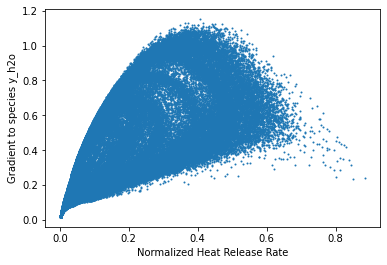

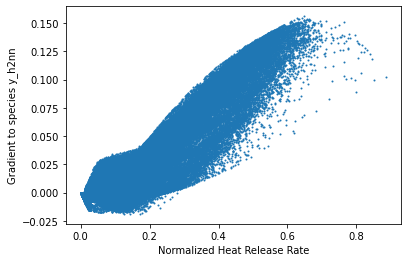

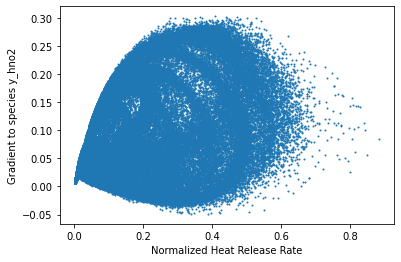

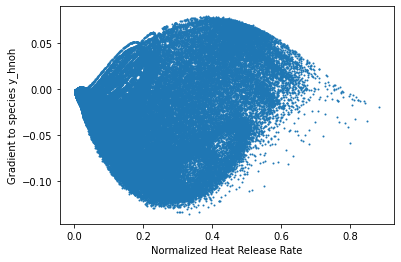

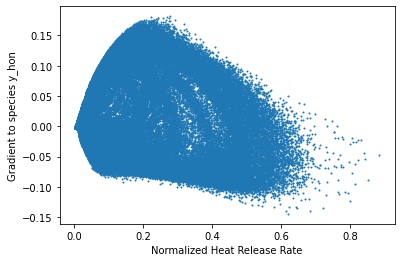

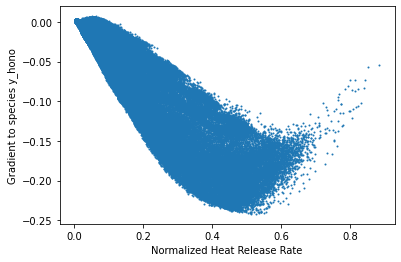

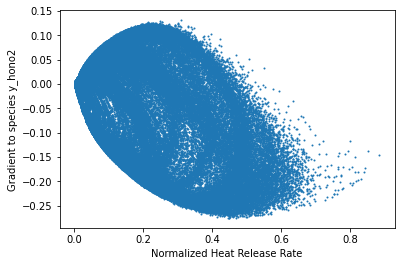

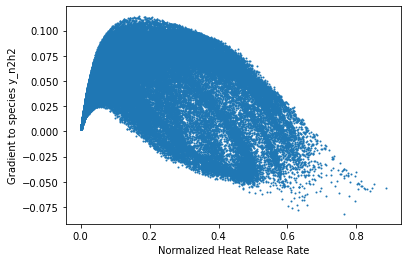

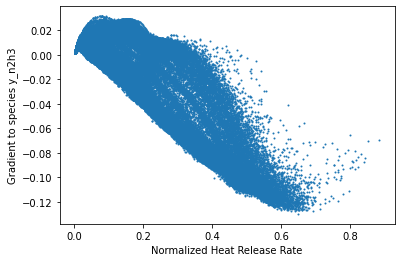

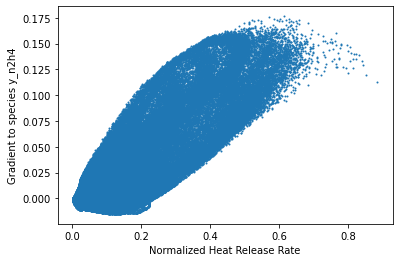

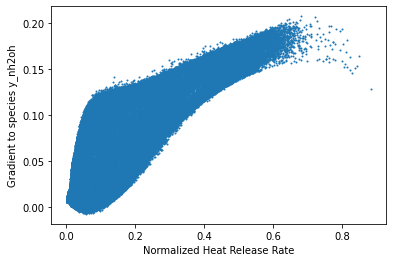

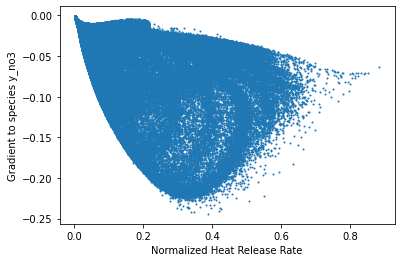

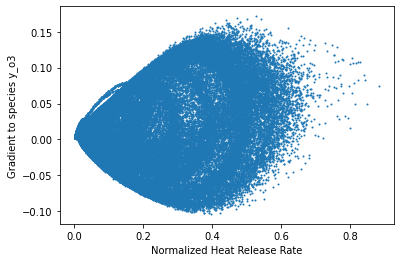

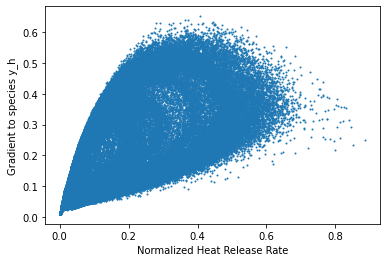

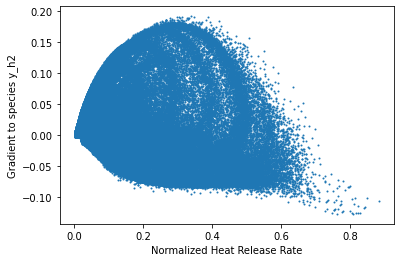

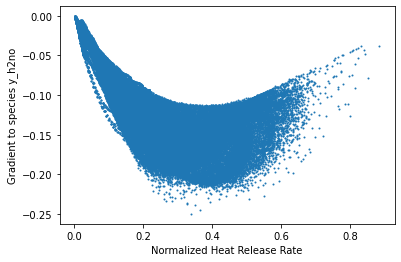

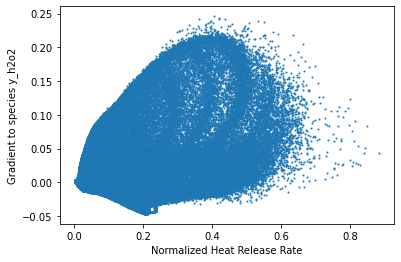

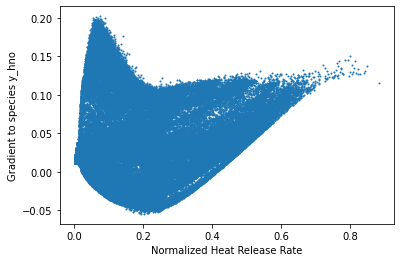

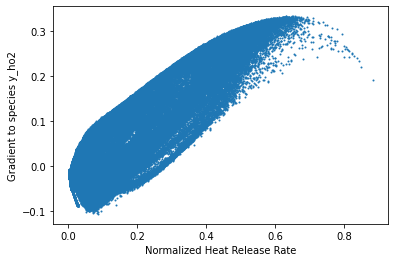

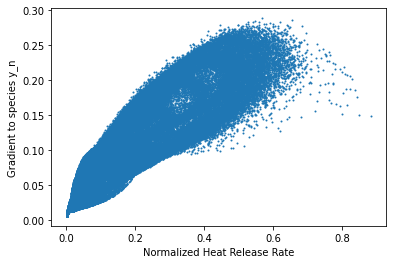

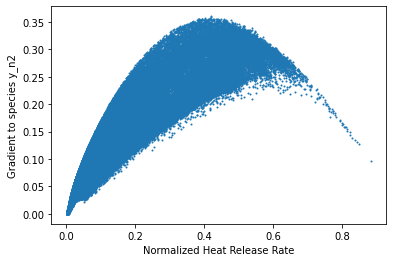

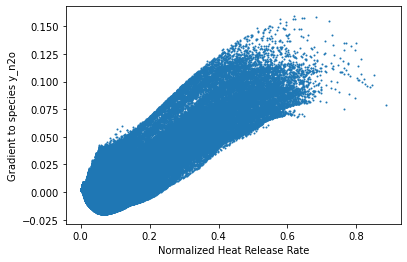

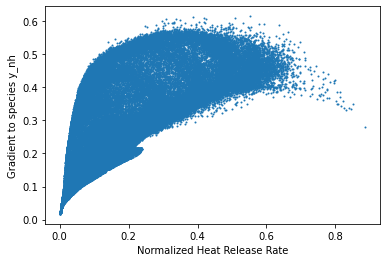

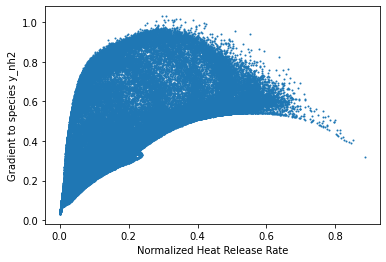

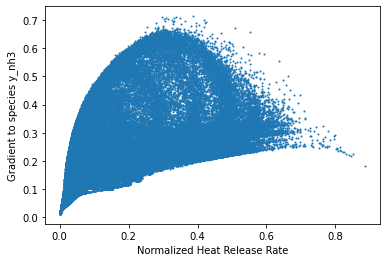

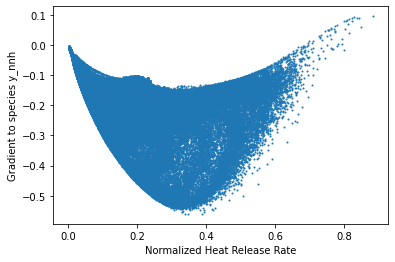

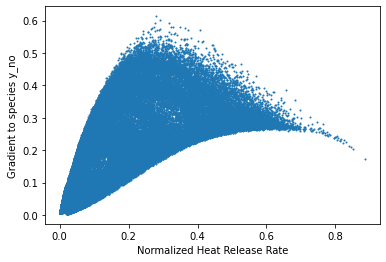

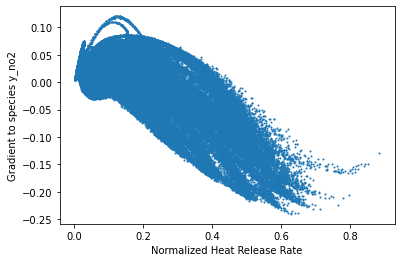

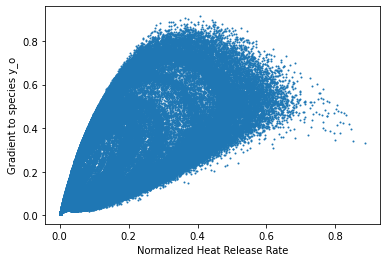

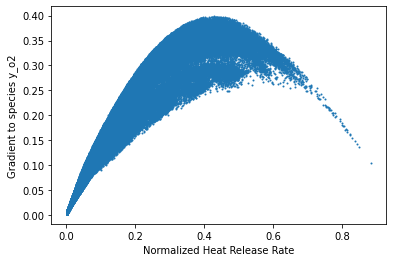

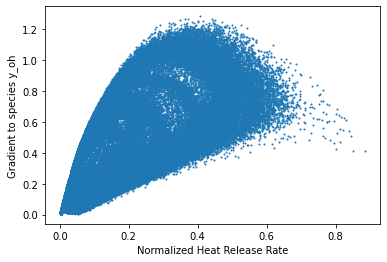

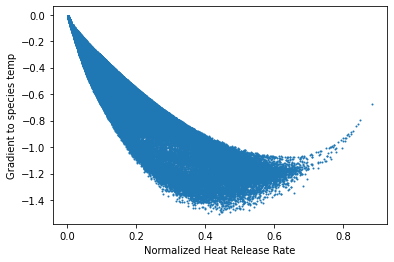

In [8]:
y = ["y_h2o", "y_h2nn", "y_hno2", "y_hnoh", "y_hon", "y_hono", "y_hono2", "y_n2h2", "y_n2h3", "y_n2h4", "y_nh2oh",
     "y_no3", "y_o3","y_h", "y_h2", "y_h2no", "y_h2o2", "y_hno", "y_ho2", "y_n", "y_n2", "y_n2o", "y_nh", "y_nh2",
     "y_nh3", "y_nnh", "y_no", "y_no2", "y_o", "y_o2", "y_oh", "temp"]
for i in range(32):
    grad_of_inp = np.array(grads[:,i])
    
    plt.figure(i)
    plt.scatter(pred, grad_of_inp, s=1)
    plt.xlabel('Normalized Heat Release Rate')
    plt.ylabel('Gradient to species '+ str(y[i]))
    plt.savefig("Gradient of output to species " + str(y[i]) + ".png")


In [12]:
NHRR_scale= np.arange(0,1.01,0.01)
conditional_mean = []
mean = []
for j in range(len(grads[1])):
    for i in range(len(NHRR_scale)-1):
        index= tf.where(np.logical_and(pred>=NHRR_scale[i], pred<=NHRR_scale[i+1]))
        mask = np.array(index[:,0]) 
        samples = np.take(grads[:,j],mask)
        cond_mean = np.mean(samples)
        cond_mean = np.nan_to_num(cond_mean)
        conditional_mean.append(cond_mean)
    mean_species= np.array(conditional_mean)
print(mean_species.shape)


(3200,)


In [13]:
# split data 
a = np.split(mean_species,32)
b = np.array(a)
print(b)
print(b.shape)

[[ 0.04761105  0.09549595  0.12677401 ...  0.          0.
   0.        ]
 [-0.00222349 -0.00230027 -0.00089155 ...  0.          0.
   0.        ]
 [ 0.01767902  0.03138133  0.03896272 ...  0.          0.
   0.        ]
 ...
 [ 0.01022155  0.02493743  0.04064376 ...  0.          0.
   0.        ]
 [ 0.0318724   0.07772546  0.11065488 ...  0.          0.
   0.        ]
 [-0.04126881 -0.10451329 -0.15605894 ...  0.          0.
   0.        ]]
(32, 100)


In [14]:
np.savetxt("mean_species.csv", b, delimiter=",")